# PyTorch Primer

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [4]:
# Uncomment to re-download the mnist dataset
# !wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# !wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# !wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# !wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
ls ../data/

t10k-images-idx3-ubyte   train-images-idx3-ubyte
t10k-labels-idx1-ubyte   train-labels-idx1-ubyte


## Data Structure

```
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```

2051 10000 28 28


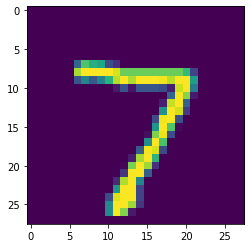

In [7]:
import struct

def read_struct(fp, fmt):
    return struct.unpack(fmt, fp.read(struct.calcsize(fmt)))

with open('../data/t10k-images-idx3-ubyte', 'rb') as fp:
#     header = fp.read(16)
#     magic, num_images, num_rows, num_cols = struct.unpack(">iiii", header)
    magic, num_images, num_rows, num_cols = read_struct(fp, ">iiii")
    assert magic == 2051
    
    print(magic, num_images, num_rows, num_cols)
    
    image = read_struct(fp, f"<{num_rows * num_cols}B")
    image = np.array(image).reshape((num_rows, num_cols))
    plt.imshow(image)

In [8]:
import struct

def read_struct(fp, fmt):
    return struct.unpack(fmt, fp.read(struct.calcsize(fmt)))

with open('../data/t10k-labels-idx1-ubyte', 'rb') as fp:
#     header = fp.read(16)
#     magic, num_images, num_rows, num_cols = struct.unpack(">iiii", header)
    magic, num_labels = read_struct(fp, ">ii")
    assert magic == 2049
    
    print(magic, num_labels)
    labels = read_struct(fp, f">{num_labels}B")
    print(labels)

2049 10000
(7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4, 2, 0, 7, 1

In [9]:
!ls ../data

t10k-images-idx3-ubyte  train-images-idx3-ubyte
t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


Showing samples [0, 1, 9]


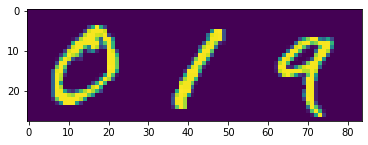

In [19]:
HEADER_FMT = ">iiii"
import os
class MNISTDataset(Dataset):
    
    def __init__(self, dataset_dir, dataset_id, label_file=None):
        # Read header
        
        image_file = os.path.join(dataset_dir, f'{dataset_id}-images-idx3-ubyte')
        self.image_fp = open(image_file, 'rb')
        self.label_file = os.path.join(dataset_dir, f'{dataset_id}-labels-idx1-ubyte')
        self._read_labels()
        self._read_images()
            

        self.offset = struct.calcsize(HEADER_FMT)
        
    def _read_labels(self):
        with open(self.label_file, 'rb') as fp:
            magic, num_labels = read_struct(fp, ">ii")
            assert magic == 2049

            self.labels = read_struct(fp, f">{num_labels}B")
            
    def _read_images(self):
        magic, self.num_images, self.num_rows, self.num_cols = read_struct(self.image_fp, ">iiii")
        self.images = []
        for idx in range(self.num_images):
            struct = read_struct(self.image_fp, f"<{self.num_rows * self.num_cols}B")
            image = torch.Tensor(struct)

            self.images.append(image)
        
    def __del__(self):
        self.image_fp.close()
        
    def __len__(self):
        return self.num_images
    
    def __getitem__(self, idx):
        if idx < len(self):
            return self.images[idx], self.labels[idx]
        else:
            raise ValueError("Out of bounds")
            
ds = MNISTDataset('../data/', 'train')

def plot_samples(*sample_indices):
    sample = [ds[i] for i in sample_indices]
    
    X = [x[0] for x in sample]
    y = [x[1] for x in sample]
    
    print("Showing samples", y)

    images = np.hstack([np.reshape(x, (ds.num_rows, ds.num_cols)) for x in X])
    plt.title = "Hello"
    
    plt.imshow(images)    

ds[0]
# images = np.hstack([np.reshape(x, (ds.num_rows, ds.num_cols)) for x in X])

plot_samples(1,3,4)

## Model Architecture

In [275]:
in_size = ds.num_rows*ds.num_cols
num_classes = 10
print(in_size)
width = 1024
model = nn.Sequential(
    nn.Linear(in_size, width),
    nn.Linear(width, width),
    nn.Dropout(0.33),
    nn.Linear(width, width),
    nn.Dropout(0.33),
    nn.Linear(width, width),
    nn.Linear(width, num_classes),  
#     nn.Softmax(dim=-1) # Do not use this with the loss function down below!!!
)

model(ds[0][0])

784


tensor([  2.5471,  -5.6968, -14.1428,  -6.6806,   5.2675,  -3.8485,  -2.0888,
          5.8132, -13.9490, -12.3886], grad_fn=<AddBackward0>)

In [214]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1),
    nn.Conv2d(1, 32, 3, 1),
    nn.MaxPool2d(3, 1)
)

model(torch.reshape(ds[0][0], [32, 1]))

RuntimeError: shape '[32, 1]' is invalid for input of size 784

In [199]:
for x in list(model.parameters()):
    print(x.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


Epoch #0
Epoch train loss =  1186.042076587677
Epoch val loss =  1.6330536990723712
Epoch #1
Epoch train loss =  580.5049537420273
Epoch val loss =  0.7869191255341185
Epoch #2
Epoch train loss =  327.08991652727127
Epoch val loss =  0.44174678528562505
Epoch #3
Epoch train loss =  250.76445691287518
Epoch val loss =  0.4802428604440486
Epoch #4
Epoch train loss =  230.23153926432133
Epoch val loss =  0.4987618425425063
Epoch #5
Epoch train loss =  220.40709473192692
Epoch val loss =  0.4843704171003179
Epoch #6
Epoch train loss =  214.06527596712112
Epoch val loss =  0.3886149592222051
Epoch #7
Epoch train loss =  208.71727912127972
Epoch val loss =  0.4375488008273409
Epoch #8
Epoch train loss =  204.29732471704483
Epoch val loss =  0.4341419237725278
Epoch #9
Epoch train loss =  201.3789619654417
Epoch val loss =  0.4076720748810058
Epoch #10
Epoch train loss =  198.7537381052971
Epoch val loss =  0.37878047659042036
Epoch #11
Epoch train loss =  195.47062385082245
Epoch val loss = 

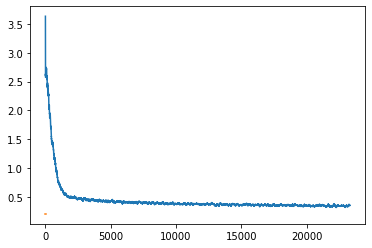

In [276]:
from torch.optim.lr_scheduler import CyclicLR

test_set =  MNISTDataset('../data/', 't10k')


# 80 / 20 split
train_size = int(len(ds) * 0.8)
test_size = int(len(ds) * 0.2)
train_set, val_set = torch.utils.data.random_split(ds, [train_size, test_size])

def val_loss():
    dl = DataLoader(val_set, shuffle=False, batch_size=128)
    losses = []
    for i, data in enumerate(dl):
        X, y = data

        y_pred = model(X)
        loss = criterion(y_pred, y)

        new_loss = loss.item()
        losses.append(new_loss)
        
    return np.mean(losses)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# scheduler = CyclicLR(optimizer, 0.001, 1)
# for lr in [0.001, 0.01, 0.1, 1, 10]:
num_epochs = 50
losses = []
criterion = nn.CrossEntropyLoss()
val_losses=[]

lr=0.1
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

for ep in range(num_epochs):
    print(f"Epoch #{ep}")
    epoch_train_loss = 0
    epoch_val_loss = 0
    dl = DataLoader(ds, shuffle=True, batch_size=128)
    for i, data in enumerate(dl):
        X, y = data
        y_pred = model(X)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()


        if i % 1000:
            new_loss = loss.item()
            scheduler.step(new_loss)
            epoch_train_loss += new_loss
            losses.append(new_loss)
            
    
    v_loss = val_loss()
    val_losses.append(v_loss)
    print("Epoch train loss = ", epoch_train_loss)
    print("Epoch val loss = ", v_loss)
#     print(f"Final lr={lr} Loss = ")

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.title = "Training Loss"
plt.plot(moving_average(losses, 100))
plt.plot(moving_average(val_losses, 100))

In [277]:
# from collections import defaultdict
# wrong_dict = defaultdict(int)

wrong_dict = {k:0 for k in range(10)}

def evaluate(model, test_set):
    
    correct = 0
    dl = DataLoader(test_set, shuffle=False, batch_size=128)
    losses = []
    for i, data in enumerate(dl):
        X, y = data

        y_pred = model(X)
        
        for y_p, y_actual in zip(y_pred, y):
#             print(y_p)
            final_y = torch.argmax(y_p).item()
#             print(final_y)
#             return
#             print(final_y, y_actual)
            if final_y == y_actual:
#                 print("Correct!")
                correct+=1
            else:
                wrong_dict[y_actual.item()] += 1
#                 print("Incorrect...")
                pass
            
    
    print(f"Accuracy = {correct/len(test_set)}")
    print("Wrong dict = ", wrong_dict)
            
            
evaluate(model, test_set)

Accuracy = 0.8992
Wrong dict =  {0: 10, 1: 18, 2: 208, 3: 113, 4: 137, 5: 124, 6: 72, 7: 87, 8: 115, 9: 124}
